In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from IPython.display import clear_output

import sys

sys.path.append("./")

import animation_utils
import importlib
import scipy.optimize as opt
from scipy import linalg 
importlib.reload(animation_utils)


%matplotlib inline

Список функций для поиска минимума:

https://en.wikipedia.org/wiki/Test_functions_for_optimization

### Beales

Рассмотрим одну из функций для оптимизации из списка - Bealses

<Axes: xlabel='$x$', ylabel='$y$'>

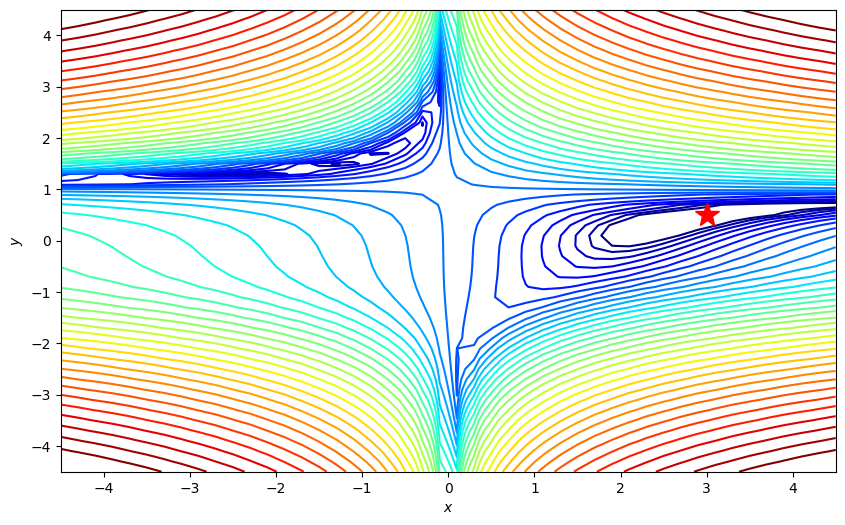

In [2]:
def beales_f(x, y):
    """функция beales"""
    return (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

def beales_f_jac(x,y):
    """якобиан функции beales"""
    dz_dx = -12.75 + 3 * y + 4.5 * y**2 + 5.25 * y**3 + 2 * x*(3 - 2 * y - y**2 - 2 * y**3 + y**4 + y**6)
    dz_dy = 6 * x * (x * (y**5 + 2/3*y**3 - y**2 - 1/3 * y - 1/3) + 2.625*y**2 + 1.5*y + 0.5)
    return np.array([dz_dx, dz_dy])

def beales_f_hess(x,y):
    """гессиан функции beales"""
    d2z_dx2 = 2 * (y**6 + y**4 - 2*y**3 - y**2 - 2*y +3)
    d2z_dy2 = 6 * x * (x * (5*y**4 + 2*y**2-2*y-1/3) + 5.25*y + 1.5)
    d2z_dx_dy = 3 + 9*y + 15.75*y**2 + 4*x*(-1 - y - 3*y**2 + 2*y**3 + 3*y**5)
    d2z_dy_dx = 3 + 9*y + 15.75*y**2 + x*(-4 - 4*y - 12*y**2 + 8*y**3 + 12*y**5)
    return np.array([[d2z_dx2, d2z_dx_dy], [d2z_dy_dx, d2z_dy2]])


def prepare_beales():
    """визуализация функции beales"""
    xmin, xmax, xstep = -4.5, 4.5, .2
    ymin, ymax, ystep = -4.5, 4.5, .2

    x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
    z = beales_f(x, y)
    # здесь используем функции из импортируемого модуля animation_utils
    return animation_utils.prepare_2d_countor_plot(x,y,z, (xmin, xmax), (ymin, ymax), np.array([3, 0.5]))
    
prepare_beales()

### Booth

<Axes: xlabel='$x$', ylabel='$y$'>

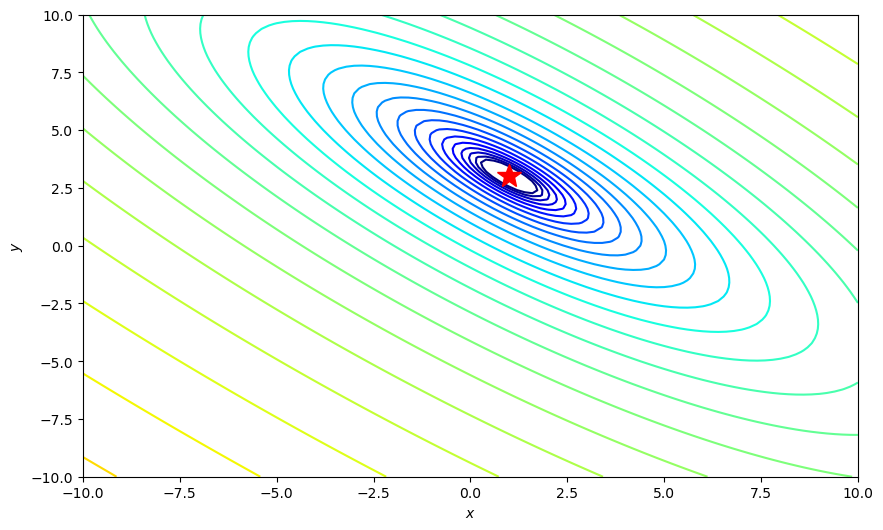

In [3]:
def booth_f(x,y):
    """функция booth"""
    return (x + 2*y - 7)**2 + (2*x + y - 5)**2

def booth_f_jac(x,y):
    """якобиан функции booth"""
    dz_dx = 10*x + 8*y - 34
    dz_dy = 8*x + 10*y - 38
    return np.array([dz_dx, dz_dy])

def booth_f_hess(x,y):
    """гессиан функции booth"""
    d2z_dx2 = 10
    d2z_dy2 = 10
    d2z_dx_dy = 8
    d2z_dy_dx = 8
    return np.array([[d2z_dx2, d2z_dx_dy], [d2z_dy_dx, d2z_dy2]])


def prepare_booth():
    xmin, xmax, xstep = -10, 10, .2
    ymin, ymax, ystep = -10, 10, .2

    x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
    z = booth_f(x, y)

    return animation_utils.prepare_2d_countor_plot(x,y,z, (xmin, xmax), (ymin, ymax), np.array([1, 3]))
    
prepare_booth()

### Алгоритмы

In [4]:
def gradient_descent(curr_point, f_grad, lr):
    """алгоритм градиентного спуска"""
    """curr_point - текущее значение параметра"""
    """f_grad - градиент потимизируемой функции, например мы передадим booth_f_jac, если оптимизируем booth_f"""
    """lr - шаг градиента"""
    x, y = curr_point[0], curr_point[1]
    grad = f_grad(x, y)#рассчет градиента
    step = lr * grad#рассчет шага градиентного спуска
    new_point = curr_point - step#обновление оптимизируемых параметров
    return new_point, step#возвращает сделанный шаг и обновленный параметр

In [5]:
def gradient_descent_with_momentum(curr_point, f_grad, step, lr, beta):
    """алгоритм градиентного спуска с инерцией"""
    """параметры алгоритма как и в gradient_descent, но добавляем beta"""
    """beta - параметр, контролирующий влияние истории градиентов на новый шаг"""
    x, y = curr_point[0], curr_point[1]
    grad = f_grad(x,y)
    # шаг состоит из сложения взвешенной истории и нового градиента в точке
    step = beta*step + (1-beta)*grad
    new_point = curr_point - lr*step
    return new_point, step

In [6]:
def adagrad(curr_point, f_grad, sum_of_grad_squared,  lr, eps):
    """алгоритм adagrad"""
    """sum_of_grad - накопленный первый момент"""
    """eps - малое число для избежания деления на 0"""
    x, y = curr_point[0], curr_point[1]
    grad = f_grad(x,y)
    #sum_of_grad_squared - вектор суммы градиентов по всем направлениям в квадрате
    #соответсвует первому моменту
    #нужен для подбора шага по каждому из направлений
    sum_of_grad_squared = sum_of_grad_squared + (grad**2)     
    step = lr * grad / (np.sqrt(sum_of_grad_squared) + eps)
    new_point = curr_point - step
    return new_point, sum_of_grad_squared, step

In [7]:
def rmsprop(curr_point, f_grad, sum_of_grad_squared,  lr, eps, beta):
    """алгоритм rmsprop"""
    """beta - параметр взвешивания"""
    x, y = curr_point[0], curr_point[1]
    grad = f_grad(x,y)
    # аналогично adagrad мы собираем сумму квадаратов градиентов по всем направлениям
    # но делаем это взвешенно с параметром beta
    # в случае с adagrad - если первые шаги градиента были большие, шаг будет маленький
    # чтобы шаг не был слишком маленький, мы взвешиеваем историю сумму квадаратов градиента и новый шаг
    sum_of_grad_squared = beta*sum_of_grad_squared + (1-beta)*(grad**2)
    step = lr * grad / (np.sqrt(sum_of_grad_squared) + eps)
    new_point = curr_point - step
    return new_point, sum_of_grad_squared, step

In [8]:
def adam(curr_point, f_grad, sum_of_grad, sum_of_grad_squared, curr_iter, beta_1, beta_2, lr, eps):
    """алгоритм adam"""
    """sum_of_grad - накопленный первый момент"""
    """sum_of_grad_squared - накопленный второй момент"""
    """curr_iter - текущая итерация оптимизации"""
    """beta_1, beta_2 - параметры взвешивания моментов"""
    x, y = curr_point[0], curr_point[1]
    grad = f_grad(x,y)
    
    # рассчет первого момента градиентов
    sum_of_grad = beta_1 * sum_of_grad + (1-beta_1) * grad
    # обратное взвешивание первого момента для того чтобы избежать стремления sum_of_grad к 0
    sum_of_grad_corrected = sum_of_grad / (1 - beta_1**curr_iter)
    
    # рассчет второго момента градиентов
    sum_of_grad_squared = beta_2 * sum_of_grad_squared + (1 - beta_2) * (grad**2)
    # обратное взвешивание первого момента для того чтобы избежать стремления sum_of_grad_squared к 0
    sum_of_grad_squared_corrected = sum_of_grad_squared / (1 - beta_2**curr_iter)
    
    step = lr * sum_of_grad_corrected / (np.sqrt(sum_of_grad_squared_corrected) + eps)
    new_point = curr_point - step
    return new_point, sum_of_grad, sum_of_grad_squared

In [9]:
def newton(curr_point, f_grad, f_hess):
    """алгоритм Ньютона"""
    x, y = curr_point[0], curr_point[1]
    newton_first_grad = f_grad(x, y)
    #рассчет 
    newton_second_grad = f_hess(x,y)
    step = np.dot(newton_first_grad, np.linalg.inv(newton_second_grad))
    new_point = curr_point - step
    return new_point

### Общий оптимизатор

In [10]:
def custom_minimizer(fun, x0, args=(), jac=None, maxfev=None, hess=None,
                     tol=1e-10, callback=None, **options):
    """общий интерфейс оптимизатора для запуска реализованных алгоритмов"""
    """x0 - начальная точка параметров"""
    """fun - оптимизируемая функция"""
    """jac - якобиан оптимизируемой функции"""
    """callback - используемый метод для работы с результатами оптимизатора"""
    """options - словарь гиперпараметров для контроля запуска оптимизатора"""
    # рассчет текущего значения
    curr_point = x0
    curr_f = fun(curr_point[0], curr_point[1])
    
    step = 0
    
    # начальные значения для первого и второго момента
    sum_of_grad = np.zeros(curr_point.reshape(1,-1).shape[1])
    sum_of_grad_squared = np.zeros(curr_point.reshape(1,-1).shape[1])
    
    funcalls = 1
    niter = 0
    improved = True
    stop = False
    
    # пока разница между прошлым значением параметра и текущим больше некоторого малого числа
    # и количетсво итераций не превышено
    while improved and not stop and niter < options['maxiter']:
        niter += 1
        
        prev_point = curr_point
        prev_f = fun(prev_point[0], prev_point[1])
        
        # рассчет следующего параметра на основании выбранного алгоритма 
        if options['algorithm'] == 'gradient_descent':
            curr_point, step = gradient_descent(prev_point, jac, **options['hyperparams'])
        if options['algorithm'] == 'gradient_descent_with_momentum':
            curr_point, step = gradient_descent_with_momentum(prev_point, jac, step, **options['hyperparams'])
        if options['algorithm'] == 'adagrad':
            curr_point, outer_matrix, step = adagrad(prev_point, jac, sum_of_grad_squared, **options['hyperparams'])
        if options['algorithm'] == 'rmsprop':
            curr_point, outer_matrix, step = rmsprop(prev_point, jac, sum_of_grad_squared, **options['hyperparams'])
        if options['algorithm'] == 'adam':
            curr_point, sum_of_grad, sum_of_grad_squared = adam(prev_point, jac, sum_of_grad, sum_of_grad_squared,  niter, **options['hyperparams'])
        if options['algorithm'] == 'newton':
            curr_point = newton(prev_point, jac, hess)
        
        curr_f = fun(curr_point[0], curr_point[1])
        
        
        funcalls += 1
        
        if np.abs(curr_f - prev_f) < tol:
            improved = False
        if callback is not None:
            callback(curr_point)
        if maxfev is not None and funcalls >= maxfev:
            stop = True
            break
    # обертка над нашим алгоритмом, для соответсвия оптимизации в библиотеке scipy
    return opt.OptimizeResult(fun=curr_f, x=curr_point, nit=niter,
                              nfev=funcalls, success = (improved == False))
    
class Reporter:
    """класс для сохранения истории обучения алгоритма для визуализации"""
    def __init__(self):
        self.history = []
        
    def __call__(self, point):
        self.history.append(point)

In [11]:
def run_optimizer(function, start_point, function_jac, function_hess, algorithm_options):
    """запуск выбранного алгоритма и возвращение его истории обучения """
    reporter = Reporter()
    reporter(x0)
    
    print(algorithm_options['algorithm'])
    optimization_result = opt.minimize(function, start_point, method=custom_minimizer, args = (), 
                 jac=function_jac, hess = function_hess, 
                 callback=reporter, options = algorithm_options)
    print(optimization_result)
    print()
    
    history = np.stack(reporter.history, axis=0).T
    return history

In [12]:
#список всех алгоритмов с их гиперпараметрами
optimization_params_list = [
                            {"algorithm": 'gradient_descent', 
                            "maxiter": 1000000,
                            "hyperparams": {"lr": 0.00005}},
                            
                        {"algorithm": 'gradient_descent_with_momentum', 
                         "maxiter": 1000000,
                         "hyperparams": {"lr": 0.00005, "beta": 0.9}},
                            
                        {"algorithm": 'adagrad', 
                        "maxiter": 1000000,
                        "hyperparams": {"lr": 0.01, "eps": 1e-8}},
                            
                        {"algorithm": 'rmsprop', 
                        "maxiter": 1000000,
                        "hyperparams": {"lr": 0.01, "eps": 1e-10, "beta": 0.9}},
                            
                        {"algorithm": 'adam', 
                        "maxiter": 1000000,
                        "hyperparams": {'beta_1': 0.9, 'beta_2': 0.999, 'lr': 0.01, 'eps': 1e-10}},
                            
                        {"algorithm": 'newton', 
                        "maxiter": 1000000}
    
]

### Booth сходимость

Запуск всех алгоритмов оптимизации для оптимизации функции Booth

In [13]:
x0 = np.array([7.5, -7.5])

optimization_history_list = []
optimization_methods_list = []

#для каждого алгоритма с его гиперпараметрами запустим оптимизатор и сохраним его историю обучения
for algo_params in optimization_params_list:
    history = run_optimizer(function=booth_f, start_point = x0, 
                           function_jac = booth_f_jac, function_hess = booth_f_hess, 
                           algorithm_options = algo_params)
    optimization_history_list.append(history)
    optimization_methods_list.append(algo_params['algorithm'])

gradient_descent
 success: True
     fun: 4.998815745940259e-07
       x: [ 1.000e+00  3.000e+00]
     nit: 97406
    nfev: 97407

gradient_descent_with_momentum
 success: True
     fun: 4.994070521410096e-07
       x: [ 1.000e+00  3.000e+00]
     nit: 97332
    nfev: 97333

adagrad
 success: False
     fun: 8.896433326320379e-05
       x: [ 1.003e+00  3.002e+00]
     nit: 1000000
    nfev: 1000001

rmsprop
 success: False
     fun: 0.007525064332323559
       x: [ 1.049e+00  2.936e+00]
     nit: 1000000
    nfev: 1000001

adam
 success: True
     fun: 6.432334482535012e-09
       x: [ 1.000e+00  3.000e+00]
     nit: 3892
    nfev: 3893

newton
 success: True
     fun: 0.0
       x: [ 1.000e+00  3.000e+00]
     nit: 2
    nfev: 3



In [14]:
optimization_history_list[-1]

array([[ 7.5,  1. ,  1. ],
       [-7.5,  3. ,  3. ]])

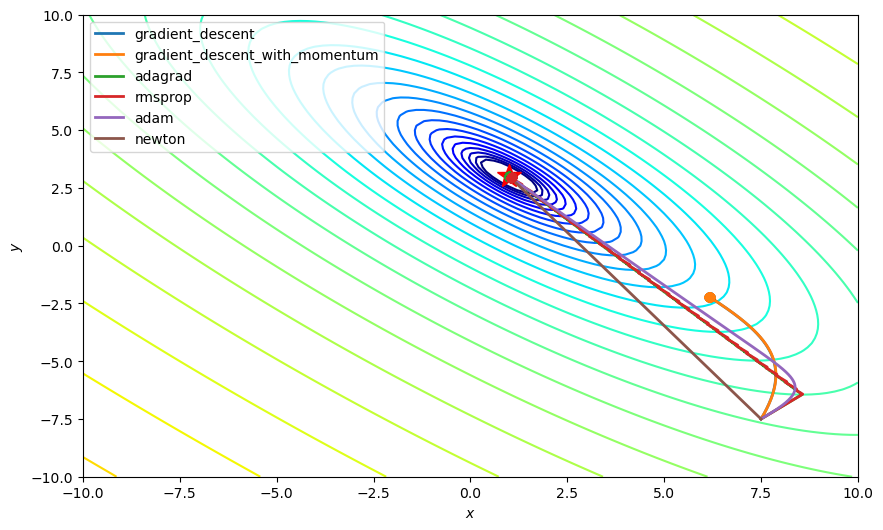

In [15]:
#визуализация алгоритма обучения
ax = prepare_booth()

skip_samples_num = 50
#https://stackoverflow.com/questions/22010586/matplotlib-animation-duration
anim = animation_utils.TrajectoryAnimation(*optimization_history_list,
                                           labels=optimization_methods_list, 
                                           skip_samples=skip_samples_num, 
                                           ax=ax, repeat_delay=5, frames=100, repeat = False)

ax.legend(loc='upper left')

anim.save('booth_optimization.gif', writer="pillow", fps=10)

### Beales сходимость

In [16]:
x0 = np.array([-3, -3])

optimization_history_list = []
optimization_methods_list = []


for algo_params in optimization_params_list:
    history = run_optimizer(function=beales_f, start_point = x0, 
                           function_jac = beales_f_jac, function_hess = beales_f_hess, 
                           algorithm_options = algo_params)
    optimization_history_list.append(history)
    optimization_methods_list.append(algo_params['algorithm'])

gradient_descent
 success: True
     fun: 3.2854006028908137e-06
       x: [ 2.995e+00  4.989e-01]
     nit: 295353
    nfev: 295354

gradient_descent_with_momentum
 success: False
     fun: 0.7012741250279863
       x: [-5.708e+00  1.152e+00]
     nit: 1000000
    nfev: 1000001

adagrad
 success: False
     fun: 0.005879323129470543
       x: [ 2.860e+00  4.524e-01]
     nit: 1000000
    nfev: 1000001

rmsprop
 success: False
     fun: 0.07158946839280778
       x: [ 2.503e+00  3.522e-01]
     nit: 1000000
    nfev: 1000001

adam
 success: True
     fun: 1.3123952053485259e-08
       x: [ 3.000e+00  4.999e-01]
     nit: 14184
    nfev: 14185

newton
 success: True
     fun: 14.203125
       x: [-7.495e-16  1.000e+00]
     nit: 42
    nfev: 43



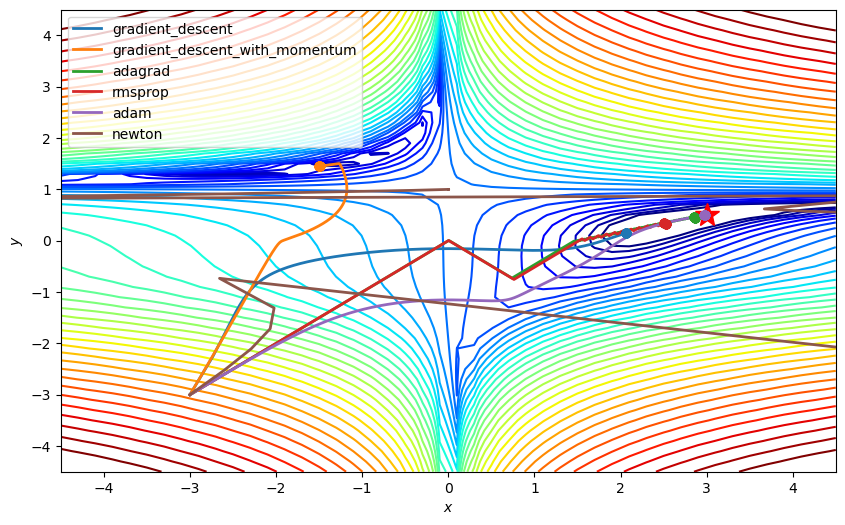

In [17]:
ax = prepare_beales()

skip_samples_num = 50
#https://stackoverflow.com/questions/22010586/matplotlib-animation-duration
anim = animation_utils.TrajectoryAnimation(*optimization_history_list,
                                           labels=optimization_methods_list, 
                                           skip_samples=skip_samples_num, 
                                           ax=ax, repeat_delay=5, frames=250, repeat = False)

ax.legend(loc='upper left')

anim.save('beales_optimization.gif', writer="pillow", fps=10)

### Практикум

### Визуализируйте поиск минимума для всех алгоритмов для любой другой функции из списка. (1 балл)

https://en.wikipedia.org/wiki/Test_functions_for_optimization

### Я выбрал Himmelblau's function, т.к. у нее несколько локальных минимумов, что позволяет нам увидеть, как алгоритмы оптимизации справляются с этим.

In [18]:
def himmelblau_f(x, y):
    """Himmelblau's function"""
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def himmelblau_f_jac(x, y):
    """Jacobian of Himmelblau's function"""
    dz_dx = 4*x*(x**2 + y - 11) + 2*(x + y**2 - 7)
    dz_dy = 2*(x**2 + y - 11) + 4*y*(x + y**2 - 7)
    return np.array([dz_dx, dz_dy])

def himmelblau_f_hess(x, y):
    """Hessian of Himmelblau's function"""
    d2z_dx2 = 4*(x**2 + y - 11) + 8*x**2 + 2
    d2z_dy2 = 2 + 4*(x + y**2 - 7) + 8*y**2
    d2z_dx_dy = 4*x + 4*y
    d2z_dy_dx = 4*x + 4*y
    return np.array([[d2z_dx2, d2z_dx_dy], [d2z_dy_dx, d2z_dy2]])

def prepare_himmelblau():
    """Visualization of Himmelblau's function"""
    xmin, xmax, xstep = -5, 5, .2
    ymin, ymax, ystep = -5, 5, .2

    x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), 
                      np.arange(ymin, ymax + ystep, ystep))
    z = himmelblau_f(x, y)
    return animation_utils.prepare_2d_countor_plot(x, y, z, 
                                                 (xmin, xmax), 
                                                 (ymin, ymax), 
                                                 np.array([3, 2]))

In [19]:
x0 = np.array([0.0, 0.0])

optimization_history_list = []
optimization_methods_list = []

for algo_params in optimization_params_list:
    history = run_optimizer(function=himmelblau_f, 
                          start_point=x0,
                          function_jac=himmelblau_f_jac, 
                          function_hess=himmelblau_f_hess,
                          algorithm_options=algo_params)
    optimization_history_list.append(history)
    optimization_methods_list.append(algo_params['algorithm'])

gradient_descent
 success: True
     fun: 3.8768243477140675e-08
       x: [ 3.000e+00  2.000e+00]
     nit: 7887
    nfev: 7888

gradient_descent_with_momentum
 success: True
     fun: 3.8287496208176747e-08
       x: [ 3.000e+00  2.000e+00]
     nit: 7879
    nfev: 7880

adagrad
 success: False
     fun: 0.0001464805823113159
       x: [ 2.998e+00  2.003e+00]
     nit: 1000000
    nfev: 1000001

rmsprop
 success: False
     fun: 0.024290589506880123
       x: [ 2.973e+00  2.024e+00]
     nit: 1000000
    nfev: 1000001

adam
 success: True
     fun: 1.8761608892840436e-09
       x: [ 3.000e+00  2.000e+00]
     nit: 840
    nfev: 841

newton
 success: True
     fun: 181.6165215225827
       x: [-2.708e-01 -9.230e-01]
     nit: 5
    nfev: 6



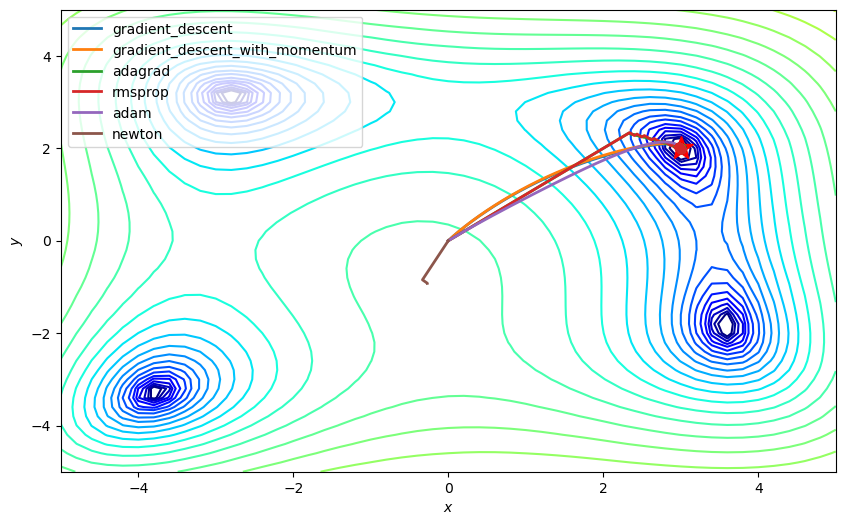

In [20]:
ax = prepare_himmelblau()

skip_samples_num = 50
anim = animation_utils.TrajectoryAnimation(*optimization_history_list,
                                         labels=optimization_methods_list,
                                         skip_samples=skip_samples_num,
                                         ax=ax, repeat_delay=5, 
                                         frames=200, repeat=False)

ax.legend(loc='upper left')
anim.save('himmelblau_optimization.gif', writer="pillow", fps=10)

### Реализуйте метод NAG и сравните скорость сходимости с другими алгоритмами. (1 балл)

In [21]:
def nesterov_accelerated_gradient(curr_point, f_grad, step, lr, beta):
    """Nesterov Accelerated Gradient (NAG) algorithm"""
    look_ahead_point = curr_point - beta * step
    
    x, y = look_ahead_point[0], look_ahead_point[1]
    grad = f_grad(x, y)
    
    step = beta * step + lr * grad
    
    new_point = curr_point - step
    
    return new_point, step

def custom_minimizer(fun, x0, args=(), jac=None, maxfev=None, hess=None,
                     tol=1e-10, callback=None, **options):
    curr_point = x0
    curr_f = fun(curr_point[0], curr_point[1])
    
    step = np.zeros_like(curr_point)
    
    sum_of_grad = np.zeros_like(curr_point)
    sum_of_grad_squared = np.zeros_like(curr_point)
    
    funcalls = 1
    niter = 0
    improved = True
    stop = False
    
    while improved and not stop and niter < options['maxiter']:
        niter += 1
        
        prev_point = curr_point
        prev_f = curr_f
        
        if options['algorithm'] == 'gradient_descent':
            curr_point, step = gradient_descent(prev_point, jac, **options['hyperparams'])
        elif options['algorithm'] == 'gradient_descent_with_momentum':
            curr_point, step = gradient_descent_with_momentum(prev_point, jac, step, **options['hyperparams'])
        elif options['algorithm'] == 'adagrad':
            curr_point, sum_of_grad_squared, step = adagrad(prev_point, jac, sum_of_grad_squared, **options['hyperparams'])
        elif options['algorithm'] == 'rmsprop':
            curr_point, sum_of_grad_squared, step = rmsprop(prev_point, jac, sum_of_grad_squared, **options['hyperparams'])
        elif options['algorithm'] == 'adam':
            curr_point, sum_of_grad, sum_of_grad_squared = adam(prev_point, jac, sum_of_grad, sum_of_grad_squared, niter, **options['hyperparams'])
        elif options['algorithm'] == 'newton':
            curr_point = newton(prev_point, jac, hess)
        elif options['algorithm'] == 'nesterov_accelerated_gradient':
            curr_point, step = nesterov_accelerated_gradient(prev_point, jac, step, **options['hyperparams'])
        
        curr_f = fun(curr_point[0], curr_point[1])
        funcalls += 1
        
        if callback is not None:
            callback(curr_point)
            
        if np.abs(curr_f - prev_f) < tol:
            improved = False
        if maxfev is not None and funcalls >= maxfev:
            stop = True
            break
            
    return opt.OptimizeResult(fun=curr_f, x=curr_point, nit=niter,
                             nfev=funcalls, success=(improved == False))

In [22]:
nag_params = {
    "algorithm": 'nesterov_accelerated_gradient', 
    "maxiter": 1000000,
    "hyperparams": {"lr": 0.00005, "beta": 0.9}
}
optimization_params_list.append(nag_params)

x0 = np.array([0.0, 0.0])

optimization_history_list = []
optimization_methods_list = []

for algo_params in optimization_params_list:
    history = run_optimizer(function=himmelblau_f, 
                          start_point=x0,
                          function_jac=himmelblau_f_jac, 
                          function_hess=himmelblau_f_hess,
                          algorithm_options=algo_params)
    optimization_history_list.append(history)
    optimization_methods_list.append(algo_params['algorithm'])

gradient_descent
 success: True
     fun: 3.8768243477140675e-08
       x: [ 3.000e+00  2.000e+00]
     nit: 7887
    nfev: 7888

gradient_descent_with_momentum
 success: True
     fun: 3.8287496208176747e-08
       x: [ 3.000e+00  2.000e+00]
     nit: 7879
    nfev: 7880

adagrad
 success: True
     fun: 6.929115057540568e-07
       x: [ 3.000e+00  2.000e+00]
     nit: 118736
    nfev: 118737

rmsprop
 success: False
     fun: 0.0018559899729078753
       x: [ 2.995e+00  1.995e+00]
     nit: 1000000
    nfev: 1000001

adam
 success: True
     fun: 1.8761608892840436e-09
       x: [ 3.000e+00  2.000e+00]
     nit: 840
    nfev: 841

newton
 success: True
     fun: 181.6165215225827
       x: [-2.708e-01 -9.230e-01]
     nit: 5
    nfev: 6

nesterov_accelerated_gradient
 success: True
     fun: 3.27626747499877e-09
       x: [ 3.000e+00  2.000e+00]
     nit: 833
    nfev: 834



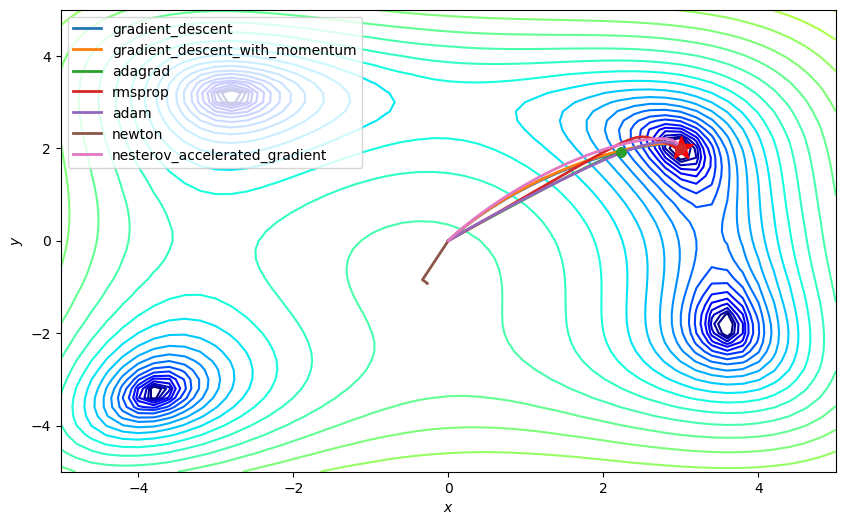

In [23]:
ax = prepare_himmelblau()

skip_samples_num = 50
anim = animation_utils.TrajectoryAnimation(*optimization_history_list,
                                         labels=optimization_methods_list,
                                         skip_samples=skip_samples_num,
                                         ax=ax, repeat_delay=5, 
                                         frames=200, repeat=False)

ax.legend(loc='upper left')
anim.save('himmelblau_optimization_with_nag.gif', writer="pillow", fps=10)

### Найдите корни квадратного уравнения с помощью градиентного спуска (1 балл)

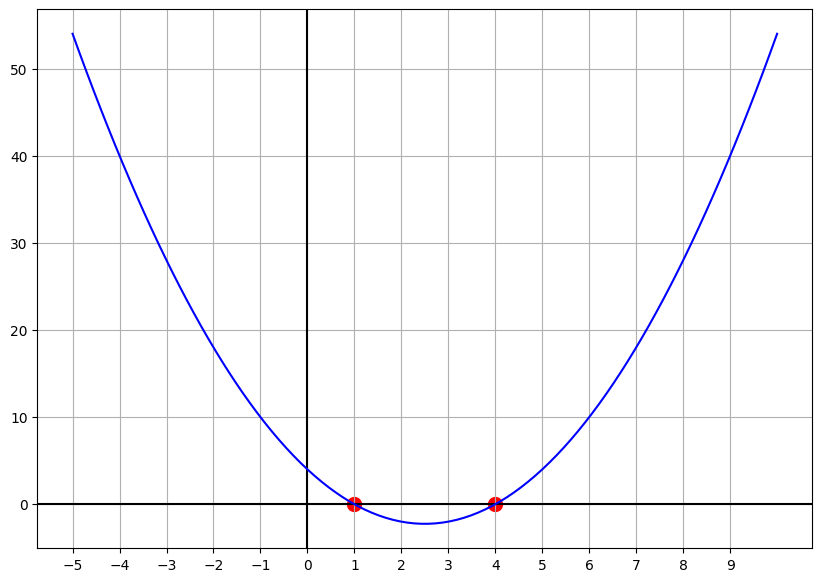

In [14]:
plt.rcParams["figure.figsize"] = (10,7)

def draw_f_plot(x_values, y_values, color):
    """функция визуализации"""
    plt.rcParams["figure.figsize"] = (10,7)
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.grid(True, which='both')
    plt.xticks(np.arange(-5, 10, 1))
    plt.yticks(np.arange(-10, 60,10))
    plt.plot(x,y, color=color)

def f(x):
    """функция квадратного уравнения"""
    return x**2 - 5*x + 4

#визуализация функции
x = np.linspace(-5,10,100)
y = np.array(list(map(f, x)))
answer_x = np.array([1,4])
answer_y = np.array([0,0])
plt.scatter(answer_x, answer_y, color='r', linewidths=5)
draw_f_plot(x,y, 'b')

In [10]:
def quadratic_gradient(x):
    """Gradient of the squared function (for finding roots)"""
    return 2 * (x**2 - 5*x + 4) * (2*x - 5)

def gradient_descent_roots(x0, lr=0.01, tol=1e-6, max_iter=10000):
    """Gradient descent to find roots"""
    x = x0
    trajectory = [x0]
    
    for i in range(max_iter):
        grad = quadratic_gradient(x)
        x = x - lr * grad
        trajectory.append(x)
        
        if abs(f(x)) < tol:
            break
    
    return x, trajectory

Starting from x0=2, found root: 1.0000, f(root)=-0.00000099
Starting from x0=3, found root: 4.0000, f(root)=-0.00000099


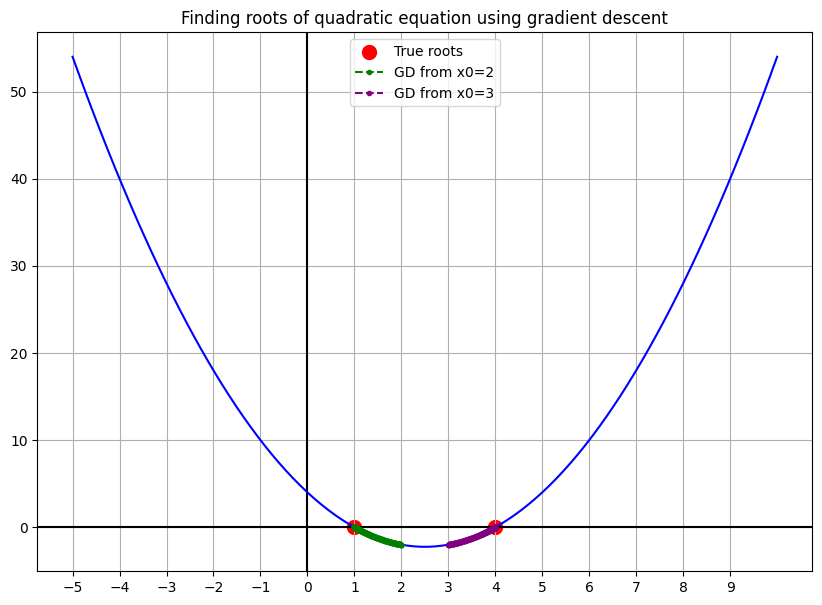

In [11]:
# Инициализация начальных точек и цветов для траекторий (просто наугад)
x0_points = [2, 3]
colors = ['g', 'purple']
trajectories = []

plt.figure(figsize=(10, 7))
draw_f_plot(x, y, 'b')
plt.scatter(answer_x, answer_y, color='r', linewidths=5, label='True roots')

for x0, color in zip(x0_points, colors):
    root, trajectory = gradient_descent_roots(x0, lr=0.001)
    trajectories.append(trajectory)
    
    trajectory_x = np.array(trajectory)
    trajectory_y = f(trajectory_x)
    plt.plot(trajectory_x, trajectory_y, color=color, linestyle='--', 
             marker='o', markersize=3, label=f'GD from x0={x0}')
    
    print(f"Starting from x0={x0}, found root: {root:.4f}, f(root)={f(root):.8f}")

plt.legend()
plt.title("Finding roots of quadratic equation using gradient descent")
plt.grid(True)
plt.show()